In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../cf-train.csv',index_col=0) # 这里用的还是obj的grade
test = pd.read_csv('../cf-testa.csv',index_col=0)

In [3]:
import psutil

## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [4]:
# 这里改了一些 Int
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['Int16', 'Int32', 'Int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'Int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('Int8')
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype('Int16')
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('Int32')
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype('Int64')
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
print("{:>20}: {:>8}".format('Original df',sizeof_fmt(train.memory_usage(index=True).sum())))

         Original df: 286.9MiB


In [6]:
train = reduce_mem_usage(train)

Mem. usage decreased to 100.71 Mb (64.9% reduction)


In [7]:
test= reduce_mem_usage(test)

Mem. usage decreased to 24.80 Mb (64.7% reduction)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  float32
 1   loanAmnt            800000 non-null  float16
 2   term                800000 non-null  float16
 3   interestRate        800000 non-null  float16
 4   installment         800000 non-null  float16
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float32
 8   employmentLength    753201 non-null  float16
 9   homeOwnership       800000 non-null  float16
 10  annualIncome        800000 non-null  float32
 11  verificationStatus  800000 non-null  float16
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  float16
 14  purpose             800000 non-null  float16
 15  postCode            799999 non-nul

In [9]:
train['grade'] = train['grade'].astype('category')

In [10]:
train['subGrade']= train['subGrade'].astype('category')
test['grade'] = test['grade'].astype('category')
test['subGrade']= test['subGrade'].astype('category')

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  200000 non-null  float32 
 1   loanAmnt            200000 non-null  float16 
 2   term                200000 non-null  float16 
 3   interestRate        200000 non-null  float16 
 4   installment         200000 non-null  float16 
 5   grade               200000 non-null  category
 6   subGrade            200000 non-null  category
 7   employmentTitle     200000 non-null  float32 
 8   employmentLength    188258 non-null  float16 
 9   homeOwnership       200000 non-null  float16 
 10  annualIncome        200000 non-null  float32 
 11  verificationStatus  200000 non-null  float16 
 12  issueDate           200000 non-null  object  
 13  purpose             200000 non-null  float16 
 14  postCode            200000 non-null  float16 
 15  regionCode       

<AxesSubplot:>

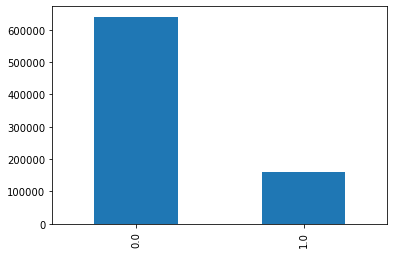

In [12]:
train['isDefault'].value_counts().sort_index().plot(kind = 'bar')

### grade 0/1

从后续的groupby来看好像不影响

不是很会，但是这里，好像grade是有一定序的关系的，

In [16]:
a0 = train.loc[train['isDefault']==1]
b0 = a0.groupby('grade')['grade'].count()
c0 = train.groupby('grade')['grade'].count()
p0 = b0/c0

<AxesSubplot:xlabel='grade'>

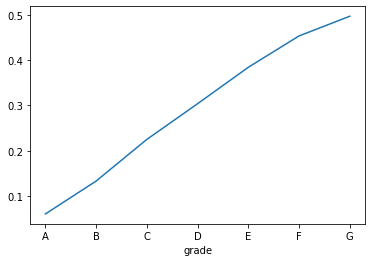

In [17]:
sns.lineplot(p0.index, p0.values)

#### subGrade 注意这里不是完全线性

In [19]:
a1 = train.loc[train['isDefault']==1]
b1 = a1.groupby('subGrade')['subGrade'].count()
c1 = train.groupby('subGrade')['subGrade'].count()
b1/c1

subGrade
A1    0.031919
A2    0.045697
A3    0.055882
A4    0.067221
A5    0.085399
B1    0.102921
B2    0.112262
B3    0.129239
B4    0.148639
B5    0.165649
C1    0.191360
C2    0.206892
C3    0.224576
C4    0.250113
C5    0.261549
D1    0.277982
D2    0.297572
D3    0.304015
D4    0.322863
D5    0.334735
E1    0.355233
E2    0.376903
E3    0.387460
E4    0.402243
E5    0.419161
F1    0.426498
F2    0.455991
F3    0.456807
F4    0.477440
F5    0.482993
G1    0.466174
G2    0.480910
G3    0.519427
G4    0.521971
G5    0.548837
Name: subGrade, dtype: float64

<AxesSubplot:xlabel='subGrade'>

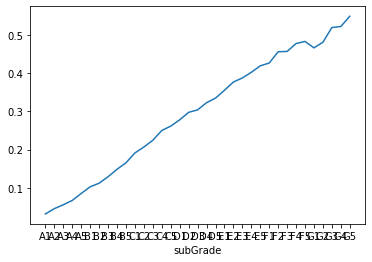

In [20]:
p1=b1/c1
sns.lineplot(p1.index, p1.values)

employmentLength

In [22]:
a2 = train.loc[train['isDefault']==0]
b2 = a2.groupby('employmentLength')['employmentLength'].count()
c2 = train.groupby('employmentLength')['employmentLength'].count()
p2 = b2/c2
p2

employmentLength
0.0     0.795118
1.0     0.794814
2.0     0.799967
3.0     0.798510
4.0     0.801709
5.0     0.804259
6.0     0.807188
7.0     0.804954
8.0     0.802774
9.0     0.801599
10.0    0.812961
Name: employmentLength, dtype: float64

<AxesSubplot:xlabel='employmentLength'>

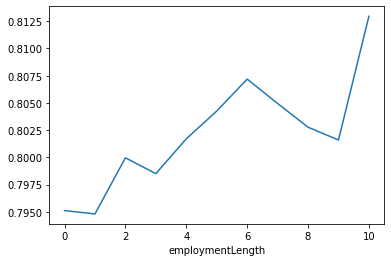

In [23]:
sns.lineplot(p2.index, p2.values)

### Santander Train & Test分布

### 结果让人迷惑

In [ ]:
"""
"""

In [ ]:
print('Train data shape:',train.shape)
print('TestA data shape:',test.shape)

In [ ]:
pd.set_option('display.max_columns', None)
train.head(10)

In [ ]:
train.info()

### grade & subgrade

In [ ]:
# train['subGrade'].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(10,6))
train[train['isDefault']==1]['ficoRangeLow'].hist(bins=30, alpha=0.5, color='blue', label='isDefault=1')
train[train['isDefault']==0]['ficoRangeLow'].hist(bins=30, alpha=0.5, color='green', label='isDefault=0')
plt.legend()
plt.xlabel('FICORangeLow')

### 就是每一组，不还的占比

In [ ]:
# train['subGrade'].value_counts().sort_values(ascending=False)

In [ ]:
# train['employmentTitle'].value_counts().sort_values(ascending=False)

In [ ]:
# test['employmentTitle'].value_counts().sort_values(ascending=False)

In [ ]:
# train['purpose'].value_counts().sort_values(ascending=False)

In [ ]:
# test['purpose'].value_counts().sort_values(ascending=False)

In [ ]:
# train['regionCode'].value_counts().sort_values(ascending=False)

In [ ]:
# test['regionCode'].value_counts().sort_values(ascending=False)

In [ ]:
# train['postCode'].value_counts().sort_values(ascending=False)

In [ ]:
# test['postCode'].value_counts().sort_values(ascending=False)

In [ ]:
# import pandas_profiling
# pfr = pandas_profiling.ProfileReport(train)
# pfr.to_file("./traineg.html")

In [ ]:
# pfr = pandas_profiling.ProfileReport(test)
# pfr.to_file("./testeg.html")

In [ ]:
test.info()